<a href="https://colab.research.google.com/github/Lasitha-Jayawardana/IDS/blob/main/K_Mean_UNSW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import math
from sklearn.cluster import KMeans
# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
from sklearn.model_selection import GridSearchCV, cross_val_score,train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix,f1_score


In [2]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IDS Project//UNSW_NB15_training-set.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IDS Project//UNSW_NB15_testing-set.csv')

for col in ['proto','service','state']:
  df_train[col] = df_train[col].astype('category')
  df_test[col] = df_test[col].astype('category')
df_train.drop_duplicates(keep='first',inplace=True)
df_test.drop_duplicates(keep='first',inplace=True)

print('Train set shape:',df_train.shape)
print('Test set shape:',df_test.shape)
print('Train',len(df_train['proto'].unique()))
print('Test',len(df_test['proto'].unique()))
print('=======================================')
print('Train',len(df_train['service'].unique()))
print('Test',len(df_test['service'].unique()))
print('=======================================')
print('Train',len(df_train['state'].unique()))
print('Test',len(df_test['state'].unique()))


Train set shape: (175341, 45)
Test set shape: (82332, 45)
Train 133
Test 131
Train 13
Test 13
Train 9
Test 7


In [3]:
df_train=df_train.drop(columns='id')
df_test=df_test.drop(columns='id')

In [13]:
df_train.columns

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [50]:
df_train.groupby('attack_cat')['attack_cat'].count()

attack_cat
Analysis           2000
Backdoor           1746
DoS               12264
Exploits          33393
Fuzzers           18184
Generic           40000
Normal            56000
Reconnaissance    10491
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64

In [5]:
df_train[df_train['label'] == 0].groupby('attack_cat')['attack_cat'].count()

attack_cat
Normal    56000
Name: attack_cat, dtype: int64

In [28]:
# Class count
count_class_0, count_class_1 = df_train['label'].value_counts()

# Divide by class
df_class_1= df_train[df_train['label'] == 0]
df_class_0 = df_train[df_train['label'] == 1]
    
df_class_0_under = df_class_0.sample(count_class_1)
df_train = pd.concat([df_class_0_under, df_class_1], axis=0)
df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

In [6]:
df_train.groupby('label')['label'].count()

label
0     56000
1    119341
Name: label, dtype: int64

In [4]:
limit1 = df_train.shape[1]-1
    
X_train = df_train.iloc[:,0:limit1-1] # train set features
Y_train = df_train.iloc[:,limit1]
    
limit2 = df_test.shape[1]-1
    
X_test = df_test.iloc[:,0:limit2-1] # test set features
Y_test = df_test.iloc[:,limit2]

In [16]:
Y_train

0         0
1         0
2         0
3         0
4         0
         ..
175336    1
175337    1
175338    1
175339    1
175340    1
Name: label, Length: 175341, dtype: int64

In [5]:
def one_hot_encode(X_train,X_test):
    
    categorical_cols = ['proto','service','state']
    # Training dataset one hot encoding
    ohe = OneHotEncoder(handle_unknown = 'ignore')
    ohe.fit(X_train[categorical_cols])
    array_hot_encoded1 = ohe.transform(X_train[categorical_cols]).toarray()

    data_hot_encoded1 = pd.DataFrame(array_hot_encoded1, index=X_train.index,columns=ohe.get_feature_names(categorical_cols))
    X_train = X_train.drop(columns=categorical_cols)
    X_train = pd.concat([data_hot_encoded1,X_train], axis=1)
    
    print('X_train shape :',X_train.shape)
    
    # Test dataset one hot encoding
    array_hot_encoded2 = ohe.transform(X_test[categorical_cols]).toarray()
    data_hot_encoded2 = pd.DataFrame(array_hot_encoded2, index=X_test.index,columns=ohe.get_feature_names(categorical_cols))
    X_test = X_test.drop(columns=categorical_cols)
    X_test = pd.concat([data_hot_encoded2,X_test], axis=1)
    
    print('X_test shape :',X_test.shape)
    
    return X_train, X_test

X_train, X_test = one_hot_encode(X_train,X_test)

X_train shape : (175341, 194)
X_test shape : (82332, 194)


In [6]:
def scaling(X_train,X_test,scaler):
  
  X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
  X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)
  return X_train,X_test

X_train, X_test = scaling(X_train,X_test,StandardScaler())

In [7]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

Y_train.reset_index(drop=True,inplace=True)
Y_test.reset_index(drop=True,inplace=True)

In [8]:
# Running K means with multible Ks
best_seed = None
final_centroids = None
final_cluster_assignment = None
X_value = X_train
min_inertia = []
#X_value = newdata.values
seeds = [0, 20000, 40000, 60000, 80000, 100000, 120000]
for seed in seeds:
  inertia = []
  no_of_clusters = range(2,10)
  print('\n\n seed= {} \n'.format(seed))
  for f in no_of_clusters:
      kmeans = KMeans(n_clusters=f, init='k-means++',random_state=seed)
      kmeans = kmeans.fit(X_value)
      
      u = kmeans.inertia_
      inertia.append(u)
      print("The innertia for :", f, "Clusters is:", u) 
      # if current measurement of heterogeneity is lower than previously seen,
      # update the minimum record of heterogeneity.
  if len(min_inertia) == 0 :
      min_inertia = inertia
      
  if min(inertia,default=0) < min(min_inertia,default=0):
      min_inertia = inertia
      best_seed = seed
      final_centroids = kmeans.cluster_centers_
      final_cluster_assignment = kmeans.labels_



 seed= 0 

The innertia for : 2 Clusters is: 31974989.303355977
The innertia for : 3 Clusters is: 31064443.944726653
The innertia for : 4 Clusters is: 30620675.153446734
The innertia for : 5 Clusters is: 30328638.56177434
The innertia for : 6 Clusters is: 30012953.299389295
The innertia for : 7 Clusters is: 29706308.447294377
The innertia for : 8 Clusters is: 29357336.275920518
The innertia for : 9 Clusters is: 29071508.084657226


 seed= 20000 

The innertia for : 2 Clusters is: 31974989.303355977
The innertia for : 3 Clusters is: 31064443.944726653
The innertia for : 4 Clusters is: 30735872.685012355
The innertia for : 5 Clusters is: 30420176.022459082
The innertia for : 6 Clusters is: 30228693.73687248
The innertia for : 7 Clusters is: 29697369.45079577
The innertia for : 8 Clusters is: 29401483.287007485
The innertia for : 9 Clusters is: 29225529.634272493


 seed= 40000 

The innertia for : 2 Clusters is: 31974989.303355977
The innertia for : 3 Clusters is: 31064443.900064297
Th

Text(0.5, 1.0, 'Inertia Plot per k for Best Seed 80000')

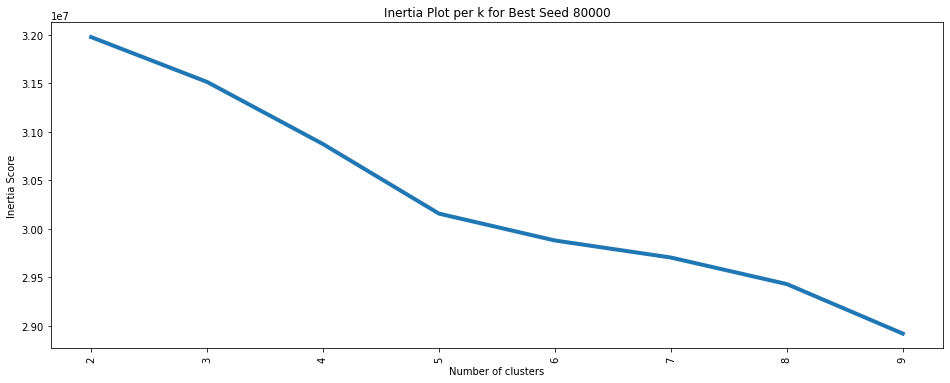

In [9]:
# Creating the scree plot for Intertia - elbow method
fig, (ax1) = plt.subplots(1, figsize=(16,6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, min_inertia,linewidth=4)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation='vertical')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia Score')
plt.title('Inertia Plot per k for Best Seed {}'.format(best_seed))

Best K value : 4


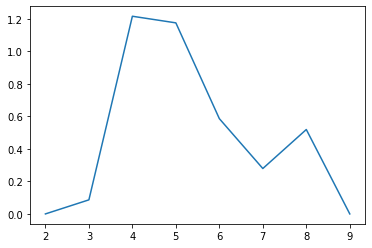

In [10]:
# between-a-point-and-a-line-in-2-d/
def calc_distance(x1, y1, a, b, c):
  d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
  return d

a = inertia[0] - inertia[-1]
b = no_of_clusters[-1] - no_of_clusters[0]
c1 = no_of_clusters[0] * inertia[-1]
c2 = no_of_clusters[-1] * inertia[0]
c = c1 - c2

r = no_of_clusters[-1]-1
r
distance_of_points_from_line = []

for k in range(int(r)):
  distance_of_points_from_line.append(
      calc_distance(no_of_clusters[k], inertia[k], a, b, c))
  
plt.plot(no_of_clusters, distance_of_points_from_line)
K =no_of_clusters[distance_of_points_from_line.index(max(distance_of_points_from_line))]
print("Best K value : {}".format(K))

In [11]:
X_trainN = X_train
X_testN = X_test

In [12]:
# Running K means with multible seeds
 
def runKmeans(X_train,no_of_clusters):

  best_seed = None


  min_inertia=0.0
  
  seeds = [0,9500,10000,10500,11000,15000,18000 , 20000, 40000, 60000, 80000,90000, 120000]
  for seed in seeds:

    
    print('\n seed= {} \n'.format(seed))
        
    kmeans = KMeans(n_clusters=no_of_clusters, init='k-means++',random_state=seed)
    kmeans = kmeans.fit(X_train)
    
    inertia = kmeans.inertia_
    print("The innertia for : 2 Clusters is:", inertia) 
    # if current measurement of heterogeneity is lower than previously seen,
    # update the minimum record of heterogeneity.
    if min_inertia == 0 :
        min_inertia = inertia
        best_seed = seed
    if inertia < min_inertia:
        min_inertia = inertia
        best_seed = seed
        

  print("\nMin inertia : ", min_inertia)
  print("Best Seed : ",best_seed)
  return best_seed
 

In [28]:
best_seed = runKmeans(X_trainN,5)


 seed= 0 

The innertia for : 2 Clusters is: 30328638.56177434

 seed= 9500 

The innertia for : 2 Clusters is: 30584214.403381333

 seed= 10000 

The innertia for : 2 Clusters is: 30206449.50829642

 seed= 10500 

The innertia for : 2 Clusters is: 30615128.350052703

 seed= 11000 

The innertia for : 2 Clusters is: 30592672.030709557

 seed= 15000 

The innertia for : 2 Clusters is: 30318629.68281465

 seed= 18000 

The innertia for : 2 Clusters is: 30429720.20283916

 seed= 20000 

The innertia for : 2 Clusters is: 30420176.022459082

 seed= 40000 

The innertia for : 2 Clusters is: 30324382.745116927

 seed= 60000 

The innertia for : 2 Clusters is: 30138241.360195767

 seed= 80000 

The innertia for : 2 Clusters is: 30156181.07424742

 seed= 90000 

The innertia for : 2 Clusters is: 30365782.62391436

 seed= 120000 

The innertia for : 2 Clusters is: 30189748.420905545

Min inertia :  30138241.360195767
Best Seed :  60000


In [29]:
# Running K means on K clusters
kmeans = KMeans(n_clusters=5,init='k-means++', random_state=best_seed)
kmeans = kmeans.fit(X_trainN)

In [13]:

def binaryaccuracyScore():
  label0 = 1- kmeans.labels_
  label1 = kmeans.labels_
  test_label1 = kmeans.predict(X_testN)
  test_label0 = 1 - test_label1

  a = accuracy_score(Y_train,label0)*100
  aa = accuracy_score(Y_train,label1)*100
  if (a>= aa):
    l = test_label0
    print("Accuracy Train: ",a)
  else:
    l = test_label1

  print("Accuracy Test: ",accuracy_score(Y_test,l)*100)

  print("\nTest set precision : {:.4f}".format(precision_score(Y_test, l)))
  print("Test set recall    : {:.4f}".format(recall_score(Y_test, l)))
  print("Test set F1-score  : {:.4f}".format(f1_score(Y_test, l)))


In [14]:
# Running K means on K clusters
kmeans = KMeans(n_clusters=2,init='k-means++', random_state=best_seed)
kmeans = kmeans.fit(X_trainN)


binaryaccuracyScore()


Accuracy Train:  66.60222081543962
Accuracy Test:  68.35616771121799

Test set precision : 0.7357
Test set recall    : 0.6637
Test set F1-score  : 0.6978


In [38]:
def multiTrain(n,label): 

  def oneVsAll(number):
    
    if (number ==nn):
      return 0
    else:
      return 1
  m=[]
  
  for i in range(0, n):
    nn=i
    m.append(accuracy_score(Y_train,np.array(list(map(oneVsAll, label)))))
    

  print("Accuracy Train: ",max(m)*100)
  
  return m.index(max(m))

In [39]:
i =multiTrain(5,kmeans.labels_)
i

Accuracy Train:  83.25605534358765


4

In [40]:
def multiTest(n,label,index): 

  def oneVsAll(number):
    if (number ==index):
      return 0
    else:
      return 1
  a=np.array(list(map(oneVsAll, label)))
  print("Accuracy Test: ",accuracy_score(Y_test,a)*100)
  print("Test set precision : {:.4f}".format(precision_score(Y_test, a)))
  print("Test set recall    : {:.4f}".format(recall_score(Y_test, a)))
  print("Test set F1-score  : {:.4f}".format(f1_score(Y_test, a)))
  cm = confusion_matrix(Y_test,a,normalize= 'true')
  print('True Positives  : {:.2f}'.format(cm[1][1]))
  print('True Negatives  : {:.2f}'.format(cm[0][0]))
  print('False Positives : {:.2f}'.format(cm[0][1]))
  print('False Negatives : {:.2f}'.format(cm[1][0]))
  

In [41]:
multiTest(5,kmeans.predict(X_testN),i)

Accuracy Test:  68.73755040567458
Test set precision : 0.6416
Test set recall    : 0.9793
Test set F1-score  : 0.7753
True Positives  : 0.98
True Negatives  : 0.33
False Positives : 0.67
False Negatives : 0.02


In [18]:
def accMultitoBinary(Y,predicted):
    
    print("Accuracy Test: ",accuracy_score(Y,predicted)*100)
    print("Test set precision : {:.4f}".format(precision_score(Y, predicted)))
    print("Test set recall    : {:.4f}".format(recall_score(Y, predicted)))
    print("Test set F1-score  : {:.4f}".format(f1_score(Y, predicted)))
    cm = confusion_matrix(Y,predicted,normalize= 'true')
    print('True Positives  : {:.2f}'.format(cm[1][1]))
    print('True Negatives  : {:.2f}'.format(cm[0][0]))
    print('False Positives : {:.2f}'.format(cm[0][1]))
    print('False Negatives : {:.2f}'.format(cm[1][0]))

In [19]:
def mapMultitoBinary(n,Trainlabel,Testlabel):
  l1=[]
  l0=[]
  def lmap(num):
    if (num in l0):
      return 0
    else:
      return 1
  
  for i in range(0, n):

    print("Cluster ", i)
    c=Y_train[Trainlabel==i]
    if (len(c[c == 1])>len(c[c == 0])):
      l1.append(i)
    else:
      l0.append(i)
    print("intrusion : ",len(c[c == 1]))
    print("normal : ",len(c[c == 0]))
  ltrain = np.array(list(map(lmap , Trainlabel)))
  print("Accuracy Train: ",accuracy_score(Y_train,ltrain)*100)
  ltest = np.array(list(map(lmap , Testlabel)))
  return ltest


In [27]:
pr = kmeans.predict(X_testN)
a = mapMultitoBinary(4,kmeans.labels_,pr)

accMultitoBinary(Y_test,a)

Cluster  0
intrusion :  40825
normal :  38264
Cluster  1
intrusion :  38373
normal :  812
Cluster  2
intrusion :  40143
normal :  14084
Cluster  3
intrusion :  0
normal :  2840
Accuracy Train:  69.68193405991752
Accuracy Test:  56.23937229752709
Test set precision : 0.5572
Test set recall    : 1.0000
Test set F1-score  : 0.7156
True Positives  : 1.00
True Negatives  : 0.03
False Positives : 0.97
False Negatives : 0.00
